In [1]:
import scipy.spatial
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import networkx as nx
from math import sqrt, pi, isclose, dist, prod

from copy import copy

from matplotlib.colors import LinearSegmentedColormap

In [2]:
def ccw(A,B,C):
    Ax,Ay=A
    Bx,By=B
    Cx,Cy=C
    return (Cy-Ay) * (Bx-Ax) > (By-Ay) * (Cx-Ax)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def edge_intersect(E,F):
    A,B = E
    C,D = F
    return intersect(A,B,C,D)

def line_intersection(E, F):
    xdiff = (E[0][0] - E[1][0], F[0][0] - F[1][0])
    ydiff = (E[0][1] - E[1][1], F[0][1] - F[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*E), det(*F))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def sign(v):
    if isclose(v,0):
        return 0
    elif v>0:
        return 1
    elif v<0:
        return -1

def point_is_LR_of_line(p, line):
    x,y=p
    A,B = line
    Ax,Ay=A
    Bx,By=B
    position = sign((Bx-Ax)*(y-Ay) - (By-Ay) * (x-Ax))
    if position is None:
        print("no side", p)
        return 0
    return position

def centroid_of_shape(S):
    length=len(S)
    if length > 0:
        mean_x=sum([x for x,y in S])/length
        mean_y=sum([y for x,y in S])/length
        if mean_x is None or mean_y is None:
            print(S, "no centroid")
        return [mean_x, mean_y]
    else:
        return None

#def pdist(p1, p2):
    

def split_shape(V,i,line):
    # Split the voronoi region located at i by
    # cutting it with a line defined by two points
    region_point_indices = V.regions[V.point_region[i]]
    region_vertices = [V.vertices[v] for v in V.regions[V.point_region[i]]]
    s_boundaries=[(region_vertices[i-1], region_vertices[i]) for i,s in enumerate(region_vertices)]
    shape_lines_and_cuts = [(e,edge_intersect(l, line), l, line_intersection(l, line) if edge_intersect(l, line) else None) for e,l in enumerate(s_boundaries)]
    return shape_lines_and_cuts

In [3]:
def genuniquecoordinates(m,n, max_iters=1000):
    seen = set()
    f=0
    while True and f<max_iters:
        x,y = random.randint(0,m), random.randint(0,n)
        if (x,y) not in seen:
            seen.add((x,y))
            yield(x,y)
        else:
            f=f+1

def gen_voronoi_points(space, number, seed=None):
    
    boundary_points=[]
    c=0
    for x in np.linspace(0, space[0],3):
        c=-space[1]
        boundary_points.append(np.array([x,c]))
    c=0
    for x in np.linspace(0, space[0],3):
        c=space[1]*2
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=-space[0]
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=space[0]*2
        boundary_points.append(np.array([x,c]))

    boundary_points=np.array(boundary_points).T

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    gencoords=genuniquecoordinates(*space)
    rand_point_coords = np.array([next(gencoords) for i in range(0,number)]).T
#    unique_rand_point_coords = np.array(list(set([tuple(c) for c in rand_point_coords.T]))).T
    unique_rand_point_coords = rand_point_coords
    point_coords= np.hstack([unique_rand_point_coords, 
                             boundary_points])
    
    vor = scipy.spatial.Voronoi(point_coords.T, furthest_site=False)
    delaunay = scipy.spatial.Delaunay(point_coords.T, furthest_site=False)
    

    return len(unique_rand_point_coords.T), vor, delaunay

In [4]:
def hexfill(r):
    return 3 * r * (r+1) + 1

def get_d(N, area):
    # Using hexpacking as optimal way of squeezing N items into a circular area:
    # https://oeis.org/A003215
    # Reversing to find approximate expected distance for N items in a given area
    # Joining points closer than this expected value results in optimal balance between
    # nothing joining and everything joining
    ratio = (1/6) * (sqrt(12 * N - 3) - 3)
    R = sqrt(area/pi)
    d = (R/ratio)
    return d

In [5]:
class cell_map(object):
    def __init__(self):
        pass

    def from_voronoi(self, V, shape2d, number_of_points):
        self.original_number_of_points = number_of_points
        self.bounds = shape2d
        self.points=np.copy(V.points)[:number_of_points]
        self.vertices=np.copy(V.vertices)
        self.point_region=np.array([v for v in range(0,number_of_points)])
        self.regions=copy(V.regions)
        self.regions = [V.regions[r] for r in [r for r in V.point_region[:number_of_points]]]
        self.centroids = self.calc_centroids()
        #print(len(self.vertices))

        cut_lines = [[[-self.bounds[0]*2, 0], [self.bounds[0]*2, 0]],
            [[self.bounds[0], -self.bounds[1]*2], [self.bounds[0], self.bounds[1]*2]],
            [[self.bounds[0]*2, self.bounds[1]], [-self.bounds[0]*2, self.bounds[1]]],
            [[0, self.bounds[1]*2], [0, -self.bounds[1]*2]]]
        
        for k in range(0,4):
            shape_count = len(self.regions)
            for i in range(0, shape_count):
                sc = split_shape(self,i,cut_lines[k])
                #print(sc[2])
                cut_locs = [c[0] for c in sc if c[1]]
                if len(cut_locs)>0:
                    #print("cut")
                    #cut_ix = [len(self.vertices),len(self.vertices)+1]
                    cut_ix=[None,None]
                    cut_vx = [c[3] for c in sc if c[1]]

                    if list(cut_vx[0]) in self.vertices.tolist():
                        replacement_index=np.where((self.vertices[:,0]==cut_vx[0][0])&(self.vertices[:,1]==cut_vx[0][1]))
                        cut_ix[0]=replacement_index[0][0]
                    else:
                        #print("adding", cut_vx[0], " at ", len(self.vertices))
                        cut_ix[0]=len(self.vertices)
                        self.vertices=np.append(self.vertices,np.array([cut_vx[0]]), axis=0)

                    if list(cut_vx[1]) in self.vertices.tolist():
                        replacement_index=np.where((self.vertices[:,0]==cut_vx[1][0])&(self.vertices[:,1]==cut_vx[1][1]))
                        cut_ix[1]=replacement_index[0][0]
                    else:
                        #print("adding", cut_vx[1], " at ", len(self.vertices))
                        cut_ix[1]=len(self.vertices)
                        self.vertices=np.append(self.vertices,np.array([cut_vx[1]]),axis=0)
                    
                    #print("build")
                    a = self.regions[self.point_region[i]][0:cut_locs[0]] + [cut_ix[0], cut_ix[1]] + self.regions[self.point_region[i]][cut_locs[1]:]
                    b = [cut_ix[0]] + self.regions[self.point_region[i]][cut_locs[0]:cut_locs[1]] + [cut_ix[1]]

                    #print(a)
                    #print(b)
                    
                    a_vertices = np.array([self.vertices[v] for v in a])
                    b_vertices = [self.vertices[v] for v in b]

                    
                    a_centroid = (sum([x for x,y in a_vertices])/len(a_vertices),sum([y for x,y in a_vertices])/len(a_vertices))
                    b_centroid = (sum([x for x,y in b_vertices])/len(b_vertices),sum([y for x,y in b_vertices])/len(b_vertices))
                    if point_is_LR_of_line(a_centroid, cut_lines[k])>0:
                        self.regions[i]=a
                        self.centroids[i]=a_centroid
                        self.regions.append(b)
                        self.centroids.append(b_centroid)
                        self.points=np.append(self.points, np.array([b_centroid]),axis=0)
                        self.point_region=np.append(self.point_region,shape_count)
                        shape_count=shape_count+1
                    else:
                        self.regions[i]=b
                        self.centroids[i]=b_centroid
                        self.regions.append(a)
                        self.centroids.append(a_centroid)
                        self.points=np.append(self.points, np.array([a_centroid]),axis=0)
                        self.point_region=np.append(self.point_region,shape_count)
                        shape_count=shape_count+1

                    if i==27:
                        print(i, cut_ix, cut_vx, a, b, self.regions[i] )
                        print("cut_locs", cut_locs)
                        print("\n".join([str(c) for c in sc]))
                else:
                    pass # print(i,cut_locs)


    def calc_centroids(self):
        centroids=[]
        for i in range(0,len(self.points)):
            region_vertices = [self.vertices[v] for v in self.regions[self.point_region[i]]]
            length=len(region_vertices)
            centroid=(sum([x for x,y in region_vertices])/length,sum([y for x,y in region_vertices])/length)
            centroids.append(centroid)
        return centroids


In [6]:
400*400

160000

In [7]:
space_dims = (200,200)
#point_opt = int(prod(space_dims)*0.00125)
point_opt = int(prod(space_dims)*0.0125)
print(point_opt)
#point_opt = int(prod(space_dims)*0.6)
number_of_points = point_opt

number_of_points,V,D = gen_voronoi_points(space_dims, number_of_points, seed=3) 
number_of_points

500


500

In [8]:
C=cell_map()
C.from_voronoi(V,space_dims, number_of_points)

(-10.0, 210.0)

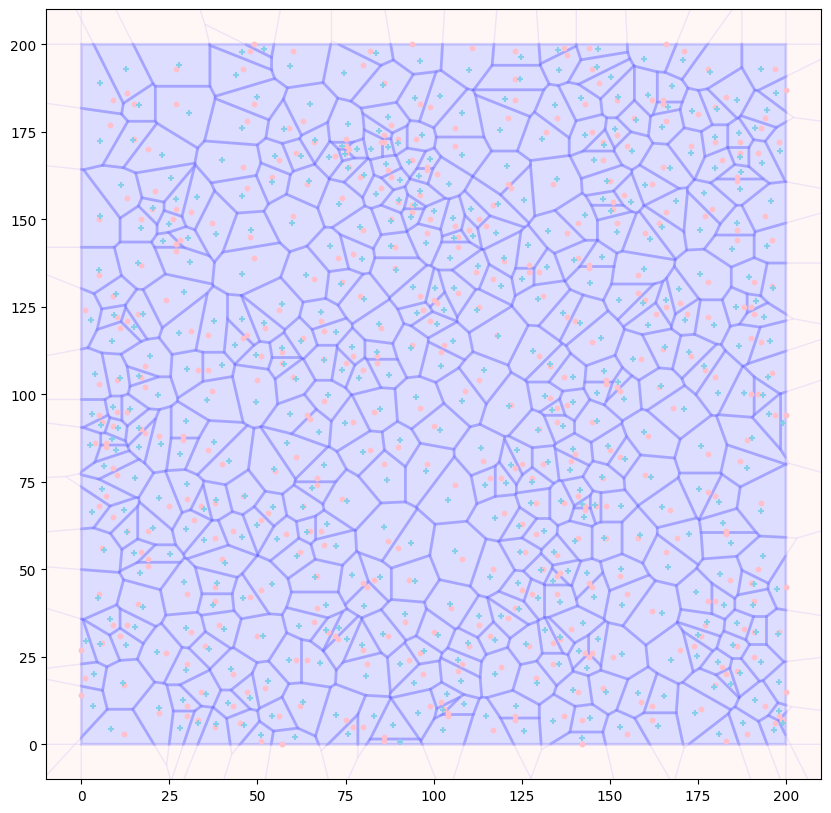

In [9]:
fig=plt.figure(figsize=(10,10))
ax = plt.gca()

for i in range(0,number_of_points):

    vi = C.regions[C.point_region[i]]
    vertices=np.array([C.vertices[v] for v in vi])
    ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='blue', facecolor = 'blue', alpha=0.135, lw=2))
    #ax.text(*np.array(C.centroids)[i],C.point_region[i], fontsize=8, color='blue')

for i in range(number_of_points,len(C.regions)):

        vi = C.regions[i]
        vertices=np.array([C.vertices[v] for v in vi])
        ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='blue', facecolor = 'red', alpha=0.035))
    
        #ax.text(*C.points[i],i, fontsize=8, color='red')
    
ax.scatter(*C.points[0:number_of_points].T, s=10, c='pink')
ax.scatter(*np.array(C.centroids)[0:number_of_points].T, s=13, marker='+', c='skyblue')
plt.xlim(-(space_dims[0]*0.05),space_dims[0]*1.05)
plt.ylim(-(space_dims[1]*0.05),space_dims[1]*1.05)

In [10]:
all_edges = [((v[e-1], v[e]),i) for i,v in enumerate(C.regions[0:number_of_points]) for e,r in enumerate(v)]
len(all_edges)

2920

In [11]:
len([e for e,c in all_edges]), len(set([e for e,c in all_edges]))

(2920, 2180)

In [12]:
def get_edge_id(edge):
    return sorted([v for v in edge])

def same_edge(e,f):
    rev_f = (f[1], f[0])
    if e==f or e==rev_f:
        return True
    else:
        return False


In [13]:
edge_id_set={}
edge_ref = dict()
for edge,cell in all_edges:
    edge_id = tuple(get_edge_id(edge))
    if edge_id not in edge_ref.keys():
        edge_ref[edge_id]=[cell]
    else:
        edge_ref[edge_id].append(cell)


In [14]:
{k:v for k,v in edge_ref.items() if 93 in v}

{(793, 794): [38, 93],
 (947, 950): [93, 339],
 (793, 950): [93, 435],
 (791, 794): [93, 346],
 (791, 851): [93, 131],
 (851, 947): [93, 358]}

In [15]:
# The cell_graph encodes all the inter-cell connections, irrespective of type
cell_graph=nx.DiGraph()
for k,v in edge_ref.items():
    if len(v)==2:
        cell_a, cell_b = v
        cell_graph.add_edge(cell_a, cell_b, data={"id":k, 
                                                  "length":dist(C.centroids[cell_a], C.centroids[cell_b]), 
                                                  "spring":1/dist(C.centroids[cell_a], C.centroids[cell_b])})
        cell_graph.add_edge(cell_b, cell_a, data={"id":k, 
                                                  "length":dist(C.centroids[cell_b], C.centroids[cell_a]), 
                                                  "spring":1/dist(C.centroids[cell_b], C.centroids[cell_a])})



In [16]:
#cell_graph=nx.DiGraph()
#for edge_a, cell_a in all_edges:
#    for edge_b, cell_b in all_edges:
#        if cell_a != cell_b:
#            if same_edge(edge_a, edge_b):
#                cell_graph.add_edge(cell_a, cell_b, data={"id":edge_a, 
#                                                              "length":dist(C.centroids[cell_a], C.centroids[cell_b]), 
#                                                              "spring":1/dist(C.centroids[cell_a], C.centroids[cell_b])})
                

In [17]:
debug = False
if debug:
    fig = plt.figure(figsize=(10,10))
    pos=nx.planar_layout(cell_graph)
    pos=nx.spring_layout(cell_graph, pos=pos, weight="spring")
    nx.draw_networkx(cell_graph, pos=pos)
else:
    print("debug is ", debug)

debug is  False


In [18]:
# The conn_graph is a sub-graph of the cell_graph that shows closely connected cells
# The connected components of the conn_graph are termed "ranges"
conn_graph = nx.Graph()
for n in cell_graph.nodes():
    conn_graph.add_node(n)
for f,t,data in cell_graph.edges(data=True):
    conn_length_test = 0.99 #+ ((random.random() - 0.5)*0.5)
    if data['data']['length']<(get_d(number_of_points, prod([*space_dims]))*conn_length_test):
        #print(f,t,data['data']['id'])
        conn_graph.add_edge(f,t)

conn_g_node_set = set([n for n in conn_graph.nodes()])
range_sets = sorted(list(nx.connected_components(conn_graph)), key=lambda x : len(x), reverse=True)
cell_range_d = {c:e for e,s in enumerate(range_sets) for c in s}

# The range_graph organises ranges (indexed according to the range_sets object) 
# such that their adjacent connections are recorded.
range_graph = nx.Graph()
range_edge_sets = set()
for range_id, cells in enumerate(range_sets):
    range_graph.add_node(range_id)
    range_cell_neighbors=set()
    for cell in cells:
        range_cell_neighbors=range_cell_neighbors.union(set(cell_graph.neighbors(cell)))
        range_range_neighbors=set([cell_range_d[n] for n in range_cell_neighbors]).difference(set([range_id]))
    for rrn in range_range_neighbors:
        if range_id !=0 or rrn !=0:
            range_graph.add_edge(range_id, rrn)

In [19]:
total_len = len(cell_graph.nodes())
sea_t = 0
sea_nodes_set = set()
shuffle_range = list(range(0,len(list(range_graph.nodes()))))
random.shuffle(shuffle_range)
#shuffle_range = random.shuffle(list(range(0,len(ranges))))
for e in shuffle_range:
    region = range_sets[e]
    #print(len(list(range_graph.neighbors(region)))/total_len)
    if e not in sea_nodes_set:
        sea_t = sea_t + (len(region)/total_len)
        sea_nodes_set.add(e)
        if sea_t > 0.60:
            break

sea_nodes_set

{1,
 2,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 93,
 94,
 95}

In [28]:
land_cols = ['#FFFB93', 
            '#5B5106'
           ]

sea_cols = [
    '#94FAFF',
    '#57a6d4'
]

def hexcol2rgb(hcol):
    rgb=tuple([int(hcol[e:e+2],16) for e in range(1,6,2)])
    return rgb



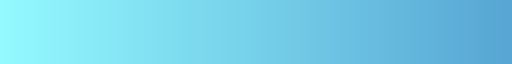

In [29]:
land_elevation_cmap = LinearSegmentedColormap.from_list("test", land_cols)
sea_depth_cmap = LinearSegmentedColormap.from_list("test", sea_cols)
land_elevation_cmap
sea_depth_cmap

In [30]:
degree_values = [v for k,v in conn_graph.degree()]
cm_gamut = np.linspace(0,1,(max(degree_values)-min(degree_values))+1)
cm_gamut

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [31]:
# Get rivers
#sea_nodes_set = set([0,1,2,3,4,5,6,7,8])
land_nodes_set = set(range_graph.nodes()).difference(sea_nodes_set)
connected_land_regions = nx.subgraph(range_graph, land_nodes_set)
continent_sets = []
connected_node_set=set([n for n,v in conn_graph.degree() if v>0])
for e,rs in enumerate(nx.connected_components(connected_land_regions)):
    print("************")
    print("**        **")
    print("** REGION **")
    print("**        **")
    print("************")
    print()
    print("River ")
    continent_set=set()
    for r in rs:
        
        #print(range_sets[r])
        continent_set=continent_set.union(set(range_sets[r]))
    continent_sets.append(continent_set)
    continent_link_set = set([tuple(sorted([f,t])) for f,t in cell_graph.edges() if f in continent_set.intersection(connected_node_set) and t in continent_set.intersection(connected_node_set)])
    continent_range_set = set([tuple(sorted([f,t])) for f,t in conn_graph.edges() if f in continent_set and t in continent_set])
    print(continent_link_set-continent_range_set)
    #print(continent_range_set)
    print()

************
**        **
** REGION **
**        **
************

River 
{(57, 329), (339, 435), (176, 286), (57, 176), (89, 406), (352, 435), (117, 355), (180, 347), (201, 443), (91, 363), (34, 195), (201, 415), (91, 329), (22, 110), (40, 299), (180, 230), (34, 133), (10, 230), (22, 76), (40, 91), (276, 322), (34, 261), (443, 481), (148, 456), (168, 230), (80, 117), (201, 456), (68, 100), (46, 100), (34, 263), (297, 356), (117, 343), (43, 247), (68, 365), (362, 409), (212, 415), (190, 247), (313, 409), (352, 425), (148, 323), (117, 409), (355, 363), (201, 323), (372, 406), (120, 352), (343, 409), (43, 205), (415, 443), (43, 406), (362, 443), (205, 432), (364, 449), (40, 355), (43, 372), (43, 143), (323, 481), (11, 276), (322, 336), (190, 372), (297, 355), (129, 261), (11, 86), (11, 205), (45, 356), (33, 336), (30, 282), (100, 365), (212, 307), (409, 443), (131, 489), (322, 432), (190, 230), (263, 364), (157, 364), (57, 286), (34, 86), (40, 117), (100, 113), (180, 286), (297, 343), (40

(-10.0, 210.0)

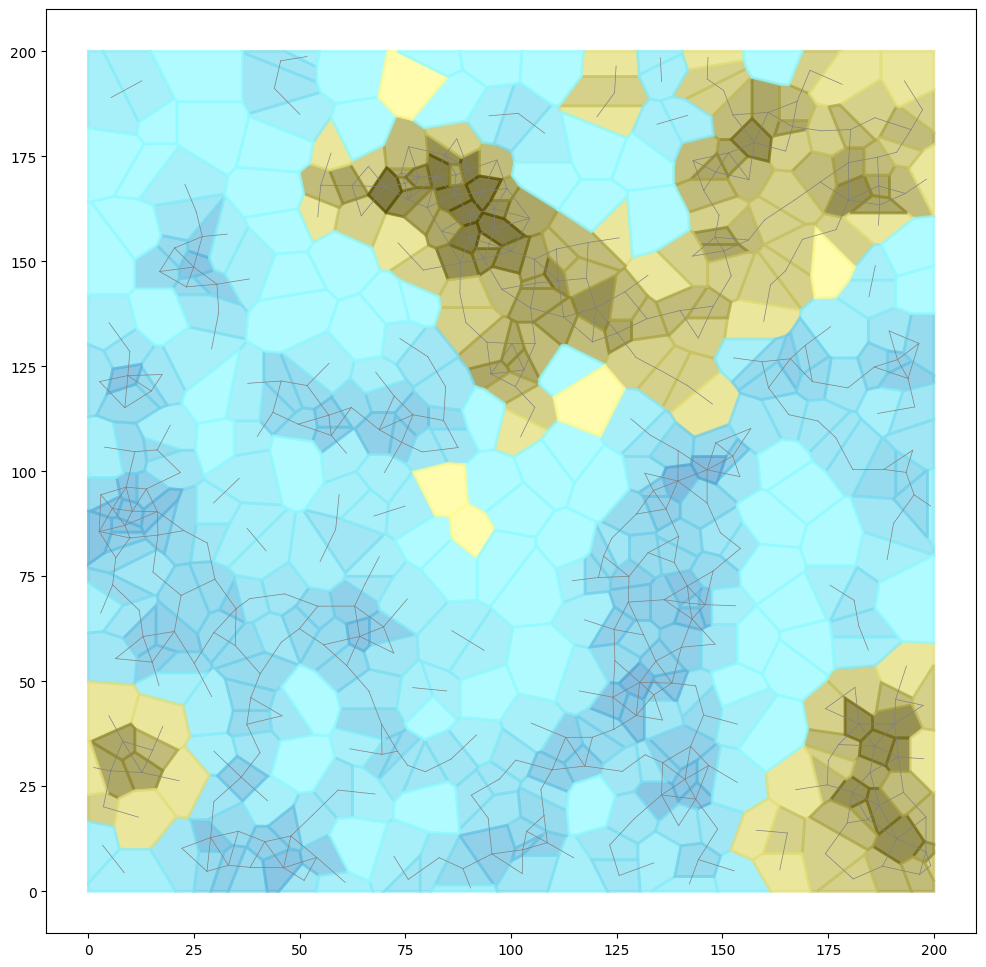

In [32]:
fig=plt.figure(figsize=(12,12))
ax = plt.gca()

for e,range_set in enumerate(range_sets):
#for comp in regions:   
    flip = random.random()
    for node in range_set:
        
        vi = C.regions[C.point_region[node]]
        vertices=np.array([C.vertices[v] for v in vi])
        
        if e not in sea_nodes_set:
            ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor=land_elevation_cmap(cm_gamut[conn_graph.degree(node)]), facecolor = land_elevation_cmap(cm_gamut[conn_graph.degree(node)]), alpha=0.75, lw=2))
            #ax.text(*np.array(C.centroids)[node],C.point_region[node], fontsize=5, color='blue')
        else:
            ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor=sea_depth_cmap(cm_gamut[conn_graph.degree(node)]), facecolor = sea_depth_cmap(cm_gamut[conn_graph.degree(node)]), alpha=0.75, lw=2))
        

points=True
for f,t in conn_graph.edges():
    if points:
        x1y1=C.centroids[f][0], C.centroids[f][1]
        x2y2=C.centroids[t][0], C.centroids[t][1]
    else:
        x1y1=C.points[f][0], C.points[f][1]
        x2y2=C.points[t][0], C.points[t][1]
    
    plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='grey',linewidth=0.5)

for node in cell_graph.nodes():
    if node not in conn_g_node_set:
        print(node)
        vi = C.regions[C.point_region[node]]
        vertices=np.array([C.vertices[v] for v in vi])
        ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='red', facecolor = 'red', alpha=0.135, lw=2))
        ax.text(*np.array(C.centroids)[node],C.point_region[node], fontsize=8, color='red')


#ax.scatter(*C.points[0:number_of_points].T, s=10, c='pink')
#ax.scatter(*np.array(C.centroids)[0:number_of_points].T, s=13, marker='+', c='skyblue')
plt.xlim(-(space_dims[0]*0.05),space_dims[0]*1.05)
plt.ylim(-(space_dims[1]*0.05),space_dims[1]*1.05)

In [26]:
continent_sets

[{2,
  9,
  10,
  11,
  16,
  22,
  30,
  33,
  34,
  35,
  38,
  40,
  43,
  45,
  46,
  57,
  68,
  74,
  75,
  76,
  80,
  86,
  88,
  89,
  91,
  93,
  94,
  100,
  102,
  105,
  106,
  110,
  113,
  117,
  120,
  125,
  129,
  131,
  133,
  137,
  139,
  143,
  148,
  157,
  162,
  168,
  176,
  180,
  190,
  194,
  195,
  201,
  205,
  212,
  218,
  226,
  230,
  247,
  257,
  261,
  263,
  267,
  268,
  276,
  282,
  284,
  286,
  297,
  299,
  303,
  306,
  307,
  313,
  322,
  323,
  327,
  329,
  336,
  339,
  342,
  343,
  346,
  347,
  352,
  355,
  356,
  358,
  362,
  363,
  364,
  365,
  372,
  373,
  383,
  390,
  397,
  406,
  407,
  408,
  409,
  410,
  413,
  415,
  425,
  432,
  435,
  443,
  449,
  455,
  456,
  457,
  481,
  484,
  487,
  489},
 {15,
  20,
  41,
  58,
  70,
  109,
  111,
  169,
  185,
  189,
  208,
  225,
  228,
  232,
  250,
  265,
  277,
  279,
  318,
  354,
  368,
  369,
  389,
  391,
  396,
  428,
  436,
  438,
  439,
  448,
  473},
 {17, 28, 

In [27]:
assert False

AssertionError: 

In [ ]:
conn_g_d = {cell:r for r,s in enumerate(range_sets) for cell in s}

In [ ]:
range_g = nx.Graph()
range_links=set()
for e,s in enumerate(range_sets):
    for cell in s:
        for n in cell_graph.neighbors(cell):
            if (e,conn_g_d[n]) not in range_links:
                range_g.add_edge(e,conn_g_d[n])
    


In [ ]:
range_g.nodes()

In [ ]:
range_g.edges()

In [ ]:
n=0.15
[n*(1.11**-e) for e in range(0,7)]

In [ ]:
processed_ranges=set()
regions=[]
n=0.15
for q in range(0,8):
    quota = n*(1.15**-q)
    print("Q", quota)
    for r_a,c_a in enumerate(range_sets):
        candidate_links=[]
        if r_a not in processed_ranges:
            candidate_region=[cell for cell in components[r_a]]
            q_filled = len(candidate_region)/cell_count
            if q_filled < quota:
                neighbs_queue=[n_b for n_b in range_g.neighbors(r_a)]
                while len(neighbs_queue)>0:
                    print("tick")
                    n_b=neighbs_queue.pop()
                    if n_b not in processed_ranges:
                        processed_ranges.add(n_b)
                        c_add = [cell for cell in components[n_b]]
                        if ((len(c_add)+len(candidate_region))/cell_count)<quota:
                            candidate_region.extend(c_add)
                            neighbs_neighbs=[n_n_b for n_n_b in set(range_g.neighbors(n_b))]
                            neighbs_queue.extend([n_n_b for n_n_b in neighbs_neighbs if n_n_b not in processed_ranges])
                        else:
                            print("adding", len(candidate_region))
                            regions.append(candidate_region)
                            break
            else:
                regions.append(candidate_region)


In [ ]:
len(regions)

In [ ]:
cell_count = len(conn_g.nodes())
components=sorted(list(nx.connected_components(conn_g)), key=lambda x : len(x), reverse=False)
regions=dict()
processed=set()
region_graph=nx.Graph()
for e,comp in enumerate(components):
    for cell in comp:
        if cell not in processed:
            for a in cell_graph.neighbors(cell):
                f = [f for f,c in enumerate(components) if a in c and c!=comp]
                if len(f)>0:
                    region_graph.add_edge(e,f[0])
                else:
                    pass
q=0
processed=set()
for region in region_graph.nodes():
    quota=n*(1.11**-q)
    print(q,quota)
    if region not in processed:
        processed.add(region)
        candidate_region=[cell for cell in components[region]]
        q_filled = len(candidate_region)/cell_count
        if q_filled < quota:
            for neighbour in region_graph.neighbors(region):
                
                if (len(components[neighbour])+len(candidate_region))/cell_count < quota:
                    print((len(components[neighbour])+len(candidate_region))/cell_count)
                    processed.add(neighbour)
                    candidate_region.extend([cell for cell in components[neighbour]])
                else:
                    # Quota reached
                    
                    regions[q]=candidate_region
                    q=q+1
                    break
        else:
            print(q_filled)
            regions[q]=candidate_region
            q=q+1
            #break

#    
#    if q_filled < quota:
#        for f,a_region in enumerate(region_graph.neighbors(e)):
#            print(a_region)
        
